<a href="https://colab.research.google.com/github/syedshoaib14/age-classification/blob/main/age_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown -q 1WDDmHkQjHpFQfKSr0mZ1gWG2_UfRdsaN
!unzip -q Segmented_datasets.zip
!rm -rf Segmented_datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1WDDmHkQjHpFQfKSr0mZ1gWG2_UfRdsaN
To: /content/Segmented_datasets.zip
100% 6.29M/6.29M [00:00<00:00, 25.1MB/s]


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, dataset
import os
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
import numpy as np
from tqdm import tqdm

In [ ]:
transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

In [ ]:
root_dir = "Segmented_datasets"

class SegmentedDataset(dataset.Dataset):
    def __init__(self, root_dir, transform=None):


        self.splits = {
            0: [0, 20],
            1: [21, 35],
            2: [36, 100]
        }
        self.num_classes = len(list(self.splits.keys()))
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        for individuals in os.listdir(root_dir):
            for file in os.listdir(os.path.join(root_dir, individuals)):
                self.data.append(Image.open(os.path.join(root_dir, individuals, file)))
                # import pdb; pdb.set_trace()
                self.labels.append(int(file.split(".jpeg")[0][:-1]) if file.split(".jpeg")[0][-1].isalpha() else int(file.split(".jpeg")[0]))

    def __len__(self):
        return len(self.data)

    def split_to_classes(self, label):

        for key, value in self.splits.items():
            if value[0] <= label <= value[1]:
                return key

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # image = Image.fromarray(image)
        if image.mode != "RGB":               # Convert grayscale to RGB
            image = image.convert("RGB")      # Back to PIL
        if self.transform:
            return self.transform(image), self.split_to_classes(label)
        return image, label


In [ ]:
ds = SegmentedDataset(root_dir, transform)
dl = DataLoader(ds, batch_size=1, shuffle=True)

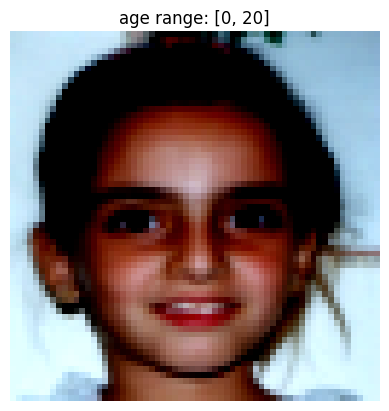

In [ ]:
images, labels = next(iter(dl))
plt.imshow(images[0].permute(1, 2, 0)/2 + 0.5)
plt.title("age range: " + str(ds.splits[int(labels[0])]))
plt.axis("off")
plt.show()

In [ ]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[6] = nn.Linear(4096, ds.num_classes)  # 3 classes changed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 141MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.0001)

In [ ]:
train_loader = DataLoader(ds, batch_size=10, shuffle=True)
test_loader = DataLoader(ds, batch_size=10, shuffle=True)

In [ ]:
num_epochs = 5  # Adjust as needed

for epoch in tqdm(range(num_epochs)):
    vgg_model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            pred = vgg_model(images)
            correct += (pred.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
        accuracy = correct / total * 100
        print(f"\nAccuracy: {accuracy:.2f}%")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

 20%|██        | 1/5 [00:03<00:14,  3.52s/it]

Accuracy: 58.51%
Epoch [1/5], Loss: 1.1783


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

Accuracy: 68.09%
Epoch [2/5], Loss: 0.9546


 60%|██████    | 3/5 [00:07<00:04,  2.30s/it]

Accuracy: 73.94%
Epoch [3/5], Loss: 0.6569


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

Accuracy: 90.43%
Epoch [4/5], Loss: 0.5687


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]

Accuracy: 94.68%
Epoch [5/5], Loss: 0.3194
Training complete!
